In [ ]:
pip install pandas --proxy http://10.3.254.50:3128

In [ ]:
pip install matplotlib --proxy http://10.3.254.50:3128

In [11]:
pip install openpyxl --proxy http://10.3.254.50:3128

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Задание: Написать код, автоматизирующий построение карт Шухарта для процесса испытания углеродных волокон на разрыв.

Исходные данные приведены в Excel-таблицах (20.xlsx, 30.xlsx, 40.xlsx). Необходимо отслеживать параметры:

Fmax;
σ_M;
dL при Fмакс.
Для мониторинга процесса нужно использовать переменные — групповое среднее и групповой размах.

По данным необходимо построить три гистограммы: одна — для всех измерений, другая — для 20 групповых средних, третья — для 20 групповых размахов.

In [16]:
df1 = pd.read_excel('20-1.xlsx')
df2 = pd.read_excel('30-1.xlsx')
df3 = pd.read_excel('40-1.xlsx')

In [17]:
# Переименум колонки
cols=  {
    'Unnamed: 0': 'Sample',
    'Eмод': 'Emod (GPa)',
    'Fmax': 'Fmax (N)',
    'sM': 'sM (MPa)',
    'dL при Fмакс': 'dL_Fmax (%)'
}

df1 = df1.rename(columns = cols).iloc[1:, :]
df2 = df2.rename(columns = cols).iloc[1:, :]
df3 = df3.rename(columns = cols).iloc[1:, :]

In [18]:
df1.head()

,Sample,Emod (GPa),Fmax (N),sM (MPa),dL_Fmax (%)
1,Образец1.1,204.848452,1827.948608,4112.884369,1.682568
2,Образец1.2,203.617195,1652.758667,3718.707001,1.576634
3,Образец1.3,219.409201,1836.640747,4132.441681,1.652574
4,Образец1.4,205.736286,1806.20813,4063.968292,1.686891
5,Образец1.5,206.353258,1835.067871,4128.90271,1.732882


In [19]:
#Объеденим их в 1 фрейм
df = pd.concat([df1, df2, df3])

In [20]:
def plot_histograms(column_name):
    data = df[column_name]

    # Разделяем данные на 20 групп
    df['Group'] = pd.cut(df.index, bins=20, labels=False)

    # Вычисление средних и размахов для каждой группы
    group_means = df.groupby('Group')[column_name].mean()
    group_ranges = df.groupby('Group')[column_name].apply(lambda x: x.max() - x.min())

    # Построение гистограмм
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    data.hist(bins=20, edgecolor='black')
    plt.title(f'Гистограмма всех измерений ({column_name})')

    plt.subplot(1, 3, 2)
    group_means.hist(bins=20, edgecolor='black')
    plt.title(f'Гистограмма групповых средних ({column_name})')

    plt.subplot(1, 3, 3)
    group_ranges.hist(bins=20, edgecolor='black')
    plt.title(f'Гистограмма групповых размахов ({column_name})')

    plt.tight_layout()
    plt.show()

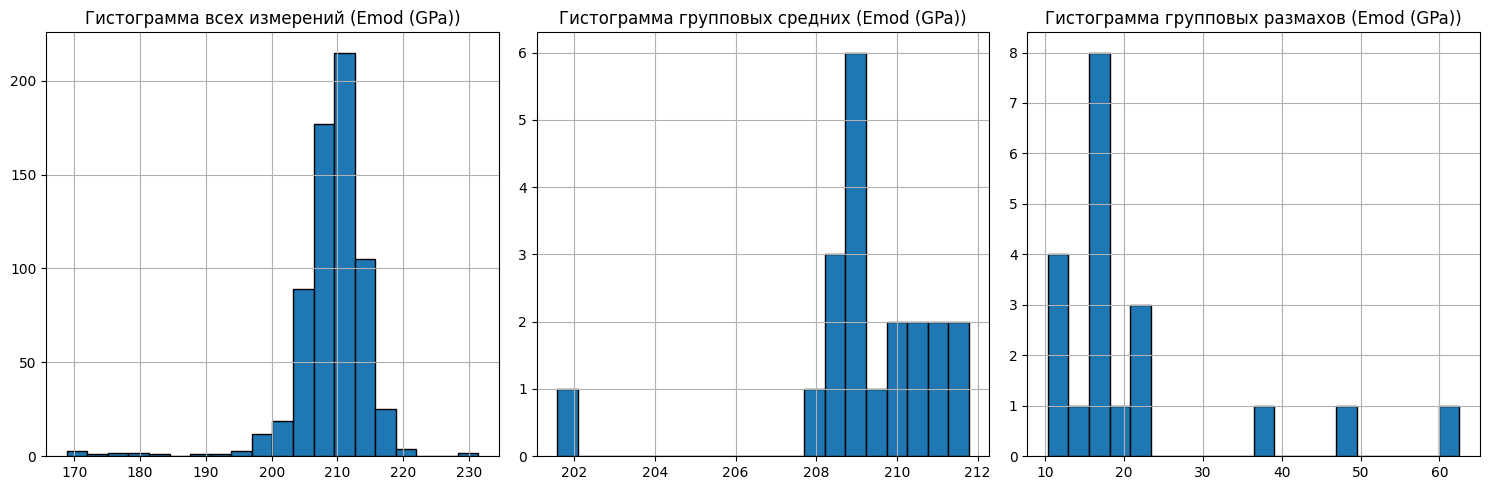

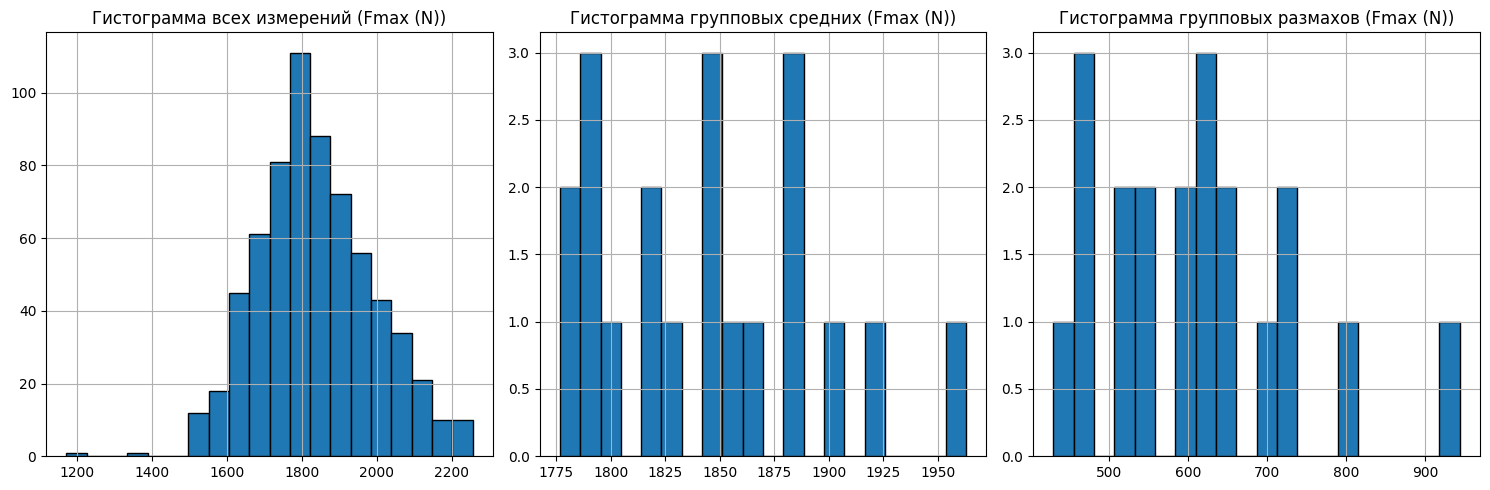

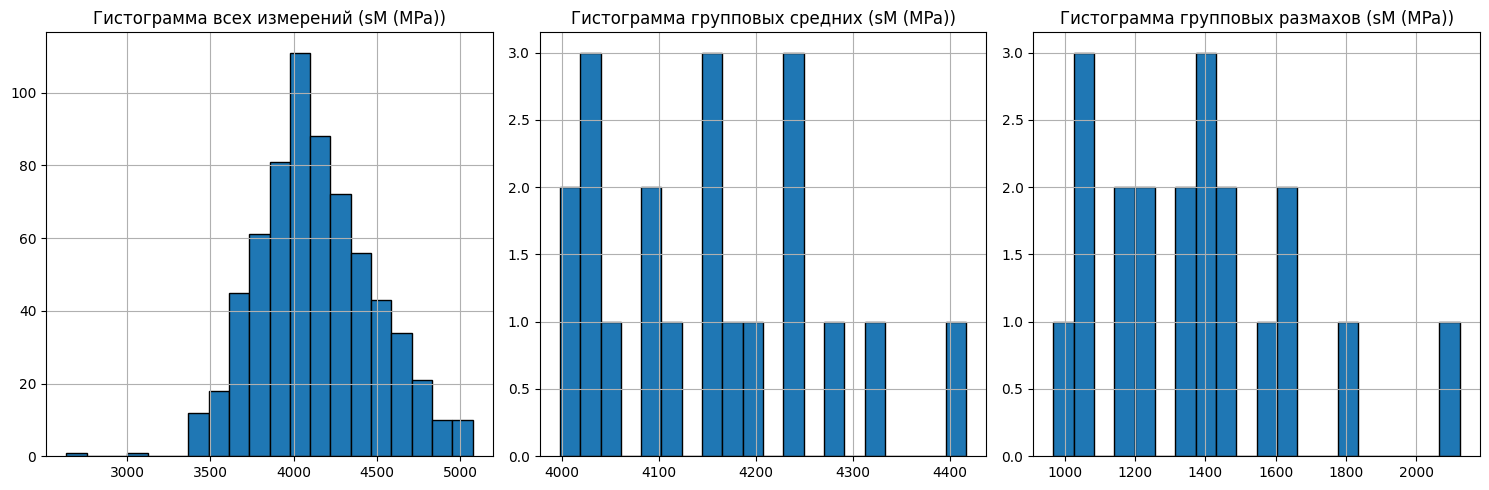

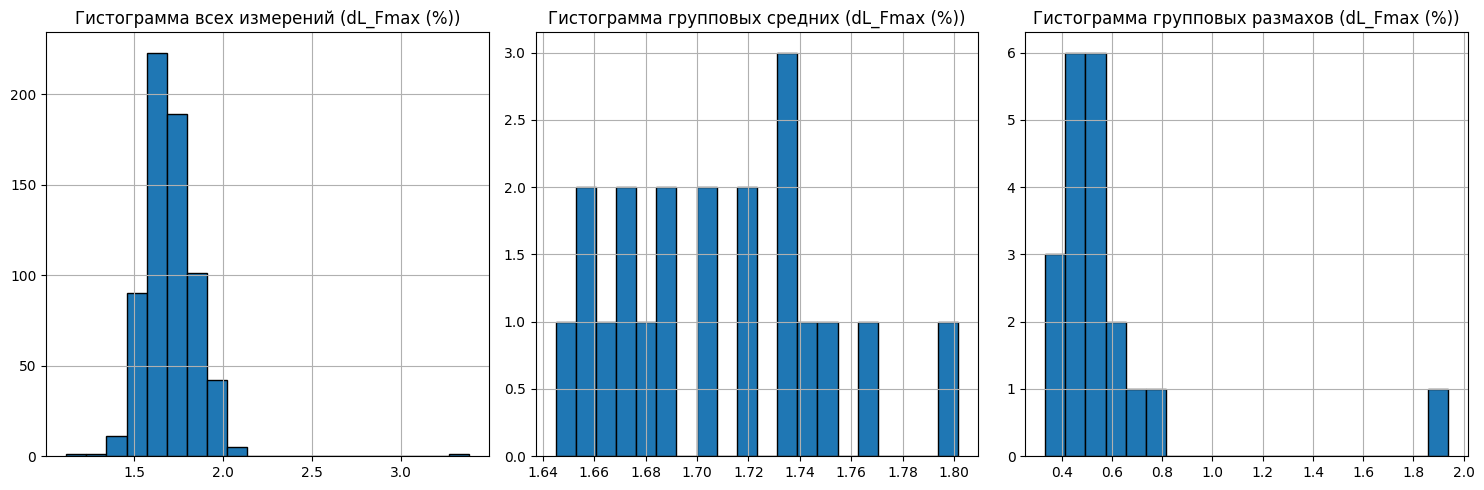

In [21]:
# Построение гистограмм для каждой колонки
columns = ['Emod (GPa)', 'Fmax (N)', 'sM (MPa)', 'dL_Fmax (%)']
for column in columns:
    plot_histograms(column)

Далее необходимо рассчитать контрольные пределы для данных, сгруппированных в k подгрупп по n элементов в каждой:
	Рассчитывается среднее и размах для каждой из k подгрупп.
	Рассчитывается среднее X ̿средних (усреднением k групповых средних).
	Усреднением групповых размахов рассчитывается средний размах R ̅.
	Центральной линией для карты средних (X-карты) будет X ̿, а для карты размахов (R-карты) - R ̅.
	Определяются значения констант А_2, D_3, D_4, соответствующих объему подгрупп, равному n (см. таблицу ниже).
	Рассчитывается произведение A_2 R ̅
	Величина, рассчитанная на шаге 6, добавляется к среднему средних, чтобы получить верхний контрольный предел X-карты: UCL_X ̅ =X ̿+A_2 R ̅.
	Величина, рассчитанная на шаге 6, вычитается из среднего средних, чтобы получить нижний контрольный предел X-карты: LCL_X ̅ =X ̿-A_2 R ̅.
	R ̅ умножается на D_4, чтобы получить верхний контрольный предел R-карты: UCL_R=D_4 R ̅.
	R ̅ умножается на D_3, чтобы получить нижний контрольный предел R-карты: LCL_R=D_3 R ̅.


|n|А_2|D_3|D_4|
|-|-|-|-|
|2  |1,880|	—	  |3,268|
|3	|1,023|	—	  |2,574|
|4	|0,729|	—	  |2,282|
|5	|0,577|	—	  |2,114|
|6	|0,483|	—	  |2,004|
|7	|0,419|	0,076 |1,924|
|8	|0,373|	0,136 |1,864|
|9	|0,337|	0,184 |1,816|
|10 |0,308|	0,223 |1,777|


In [25]:
# Функция для расчета контрольных пределов
def calculate_control_limits(column_name):
    data = df[column_name]
    
    # Разделение данных на подгруппы
    df['Group'] = pd.cut(df.index, bins=20, labels=False)
    
    # Вычисление средних и размахов для каждой подгруппы
    group_means = df.groupby('Group')[column_name].mean()
    group_ranges = df.groupby('Group')[column_name].apply(lambda x: x.max() - x.min())

    # Расчет X̿ и R̅
    X_ = group_means.mean()
    R_ = group_ranges.mean()

    # Константы для контрольных пределов (для n = 5)
    A2 = 0.577
    D3 = 0
    D4 = 2.114

    # Расчет контрольных пределов для X-карты
    UCL_X = X_ + A2 * R_
    LCL_X = X_ - A2 * R_

    # Расчет контрольных пределов для R-карты
    UCL_R = D4 * R_
    LCL_R = D3 * R_

    return X_, R_, UCL_X, LCL_X, UCL_R, LCL_R, group_means, group_ranges

In [27]:
# Горлов Артём
# Расчёт для колонки Fmax(N)
X_, R_, UCL_X, LCL_X, UCL_R, LCL_R, group_means, group_ranges = calculate_control_limits('Fmax (N)')

print(f'Среднее средних (X̿): {X_}')
print(f'Средний размах (R̅): {R_}')
print(f'Верхний контрольный предел X-карты (UCL_X): {UCL_X}')
print(f'Нижний контрольный предел X-карты (LCL_X): {LCL_X}')
print(f'Верхний контрольный предел R-карты (UCL_R): {UCL_R}')
print(f'Нижний контрольный предел R-карты (LCL_R): {LCL_R}')

Среднее средних (X̿): 1845.2689850570812
Средний размах (R̅): 611.3366821289062
Верхний контрольный предел X-карты (UCL_X): 2198.01025064546
Нижний контрольный предел X-карты (LCL_X): 1492.5277194687023
Верхний контрольный предел R-карты (UCL_R): 1292.3657460205077
Нижний контрольный предел R-карты (LCL_R): 0.0


In [28]:
def plot_map(column_name):
    # Расчет контрольных пределов
    X_, R_, UCL_X, LCL_X, UCL_R, LCL_R, group_means, group_ranges = calculate_control_limits(column_name)

    # Построение временных графиков
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(group_means, marker='o', linestyle='-')
    plt.axhline(UCL_X, color='r', linestyle='--', label='UCL')
    plt.axhline(X_, color='g', linestyle='-', label='Среднее')
    plt.axhline(LCL_X, color='r', linestyle='--', label='LCL')
    plt.title(f'X-карта ({column_name})')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(group_ranges, marker='o', linestyle='-')
    plt.axhline(UCL_R, color='r', linestyle='--', label='UCL')
    plt.axhline(R_, color='g', linestyle='-', label='Среднее')
    plt.axhline(LCL_R, color='r', linestyle='--', label='LCL')
    plt.title(f'R-карта ({column_name})')
    plt.legend()

    plt.tight_layout()
    plt.show()

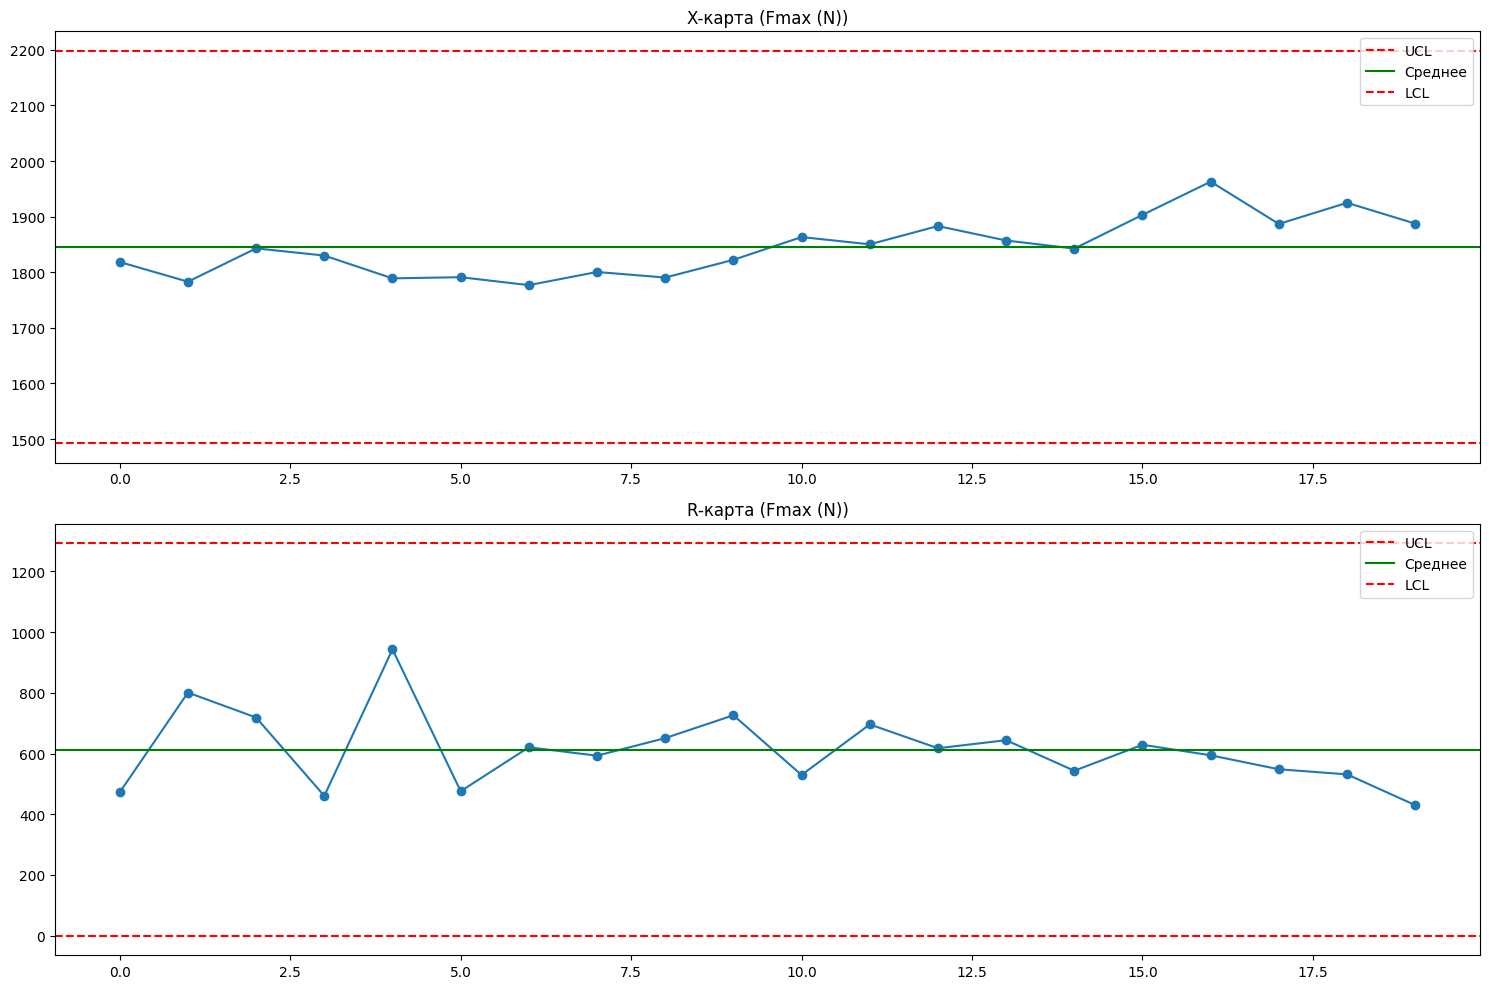

In [29]:
# Карта Шухарта для 'Fmax (N)'
plot_map('Fmax (N)')